<a href="https://colab.research.google.com/github/MeghaShyamy/rice-leaf/blob/main/rice-leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# # !pip install albumentations==0.4.6
# !pip install numpy==1.24.3
# !pip install albumentations==0.4.6 --no-cache-dir --force-reinstall
# !pip install tensorflowjs --ignore-installed
# !pip install tensorflow keras numpy opencv-python albumentations matplotlib numpy tensorflowjs


In [24]:
# !pip install --upgrade tensorflow

In [25]:
# Check the tensorflow version

import tensorflow as tf
tf.__version__

'2.18.0'

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensorV2


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline


In [28]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3


In [29]:
os.listdir('/content/drive/MyDrive/archive/')

['rice_leaf_diseases']

## Helper Functions

In [30]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




## Prepare the Data

### Create a dataframe containing all the images

In [31]:
leaf_smut_list = \
os.listdir('/content/drive/MyDrive/archive/rice_leaf_diseases/Leaf smut')
brown_spot_list = \
os.listdir('/content/drive/MyDrive/archive/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('/content/drive/MyDrive/archive/rice_leaf_diseases/Bacterial leaf blight')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

40
40
40


In [32]:
# Create the train and val sets

df_leaf_smut = pd.DataFrame(leaf_smut_list, columns=['image'])
df_leaf_smut['target'] = 'leaf_smut'

df_brown_spot = pd.DataFrame(brown_spot_list, columns=['image'])
df_brown_spot['target'] = 'brown_spot'

df_bacterial_leaf_blight = pd.DataFrame(bacterial_leaf_blight_list, columns=['image'])
df_bacterial_leaf_blight['target'] = 'bacterial_leaf_blight'


# Create a val set for each class

# Sample 5 validation images from each class
df_leaf_smut_val = df_leaf_smut.sample(n=5, random_state=101)
df_brown_spot_val = df_brown_spot.sample(n=5, random_state=101)
df_bacterial_leaf_blight_val = df_bacterial_leaf_blight.sample(n=5, random_state=101)


print(len(df_leaf_smut_val))
print(len(df_brown_spot_val))
print(len(df_bacterial_leaf_blight_val))

5
5
5


In [33]:
# Create the train set for each class

# leaf_smut
# get a list of val images
val_list = list(df_leaf_smut_val['image'])
# filter out the val images
df_leaf_smut_train = df_leaf_smut[~df_leaf_smut['image'].isin(val_list)] # ~ means notin

# brown_spot
# get a list of val images
val_list = list(df_brown_spot_val['image'])
# filter out the val images
df_brown_spot_train = df_brown_spot[~df_brown_spot['image'].isin(val_list)] # ~ means notin

# bacterial_leaf_blight
# get a list of val images
val_list = list(df_bacterial_leaf_blight_val['image'])
# filter out the val images
df_bacterial_leaf_blight_train = \
df_bacterial_leaf_blight[~df_bacterial_leaf_blight['image'].isin(val_list)] # ~ means notin



print(len(df_leaf_smut_train))
print(len(df_brown_spot_train))
print(len(df_bacterial_leaf_blight_train))

35
35
35


In [34]:
# Create df_data, df_train and df_val

df_data = pd.concat([df_leaf_smut, df_brown_spot, df_bacterial_leaf_blight], axis=0).reset_index(drop=True)

df_train = \
pd.concat([df_leaf_smut_train, df_brown_spot_train, df_bacterial_leaf_blight_train], axis=0).reset_index(drop=True)

df_val = \
pd.concat([df_leaf_smut_val, df_brown_spot_val, df_bacterial_leaf_blight_val], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)
df_train = shuffle(df_train)
df_val = shuffle(df_val)

print(df_data.shape)
print(df_train.shape)
print(df_val.shape)

(120, 2)
(105, 2)
(15, 2)


In [35]:
df_data['target'].value_counts()

,count
target,
bacterial_leaf_blight,40
leaf_smut,40
brown_spot,40


In [36]:
df_train['target'].value_counts()

,count
target,
bacterial_leaf_blight,35
leaf_smut,35
brown_spot,35


In [37]:
df_val['target'].value_counts()

,count
target,
leaf_smut,5
bacterial_leaf_blight,5
brown_spot,5


### Transform the target

Here we will one hot encode the target classes.

In [38]:
# Create the target as index values

# combine val, train and test
val_len = len(df_val)
train_len = len(df_train)
df_combined =  pd.concat(objs=[df_val, df_train], axis=0).reset_index(drop=True)

# create the dummy variables
df_combined = pd.get_dummies(df_combined, columns=['target'])

# separate the train and val sets
df_val = df_combined[:val_len]
df_train = df_combined[val_len:]


print(df_train.shape)
print(df_val.shape)

(105, 4)
(15, 4)


In [39]:
df_combined.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0308.JPG,False,False,True
1,DSC_0385.jpg,True,False,False
2,DSC_0292.JPG,False,True,False
3,DSC_0703.JPG,True,False,False
4,DSC_0505.jpg,False,False,True


In [40]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0399.JPG,True,False,False
16,DSC_0509.jpg,False,False,True
17,DSC_0508.jpg,False,False,True
18,DSC_0304.JPG,False,True,False
19,DSC_0295.JPG,False,True,False


In [41]:
df_val.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
0,DSC_0308.JPG,False,False,True
1,DSC_0385.jpg,True,False,False
2,DSC_0292.JPG,False,True,False
3,DSC_0703.JPG,True,False,False
4,DSC_0505.jpg,False,False,True


## Save the dataframes as compressed csv files
These csv files will allow us to use Pandas chunking to feed images into the generators.

In [42]:
df_combined.to_csv('df_combined.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)


In [43]:
!ls

2  df_combined.csv.gz  df_train.csv.gz	df_val.csv.gz  drive  image_dir22  sample_data


### Move all images to the same folder

In [44]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

!ls

2  df_combined.csv.gz  df_train.csv.gz	df_val.csv.gz  drive  image_dir  image_dir22  sample_data


In [45]:
leaf_smut_list = \
os.listdir('/content/drive/MyDrive/archive/rice_leaf_diseases/Leaf smut')
brown_spot_list = \
os.listdir('/content/drive/MyDrive/archive/rice_leaf_diseases/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('/content/drive/MyDrive/archive/rice_leaf_diseases/Bacterial leaf blight')


# Transfer the leaf_smut images
for fname in leaf_smut_list:

    path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Leaf smut/'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)




# Transfer the brown_spot images
for fname in brown_spot_list:

    path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Brown spot/'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)




# Transfer the bacterial_leaf_blight images
for fname in bacterial_leaf_blight_list:

    path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Bacterial leaf blight/'

    # source path to image
    src = os.path.join(path, fname)
    # destination path to image
    dst = os.path.join(image_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


In [46]:
# Check how many images are now in image_dir

len(os.listdir('image_dir'))

120

## Display some images by class

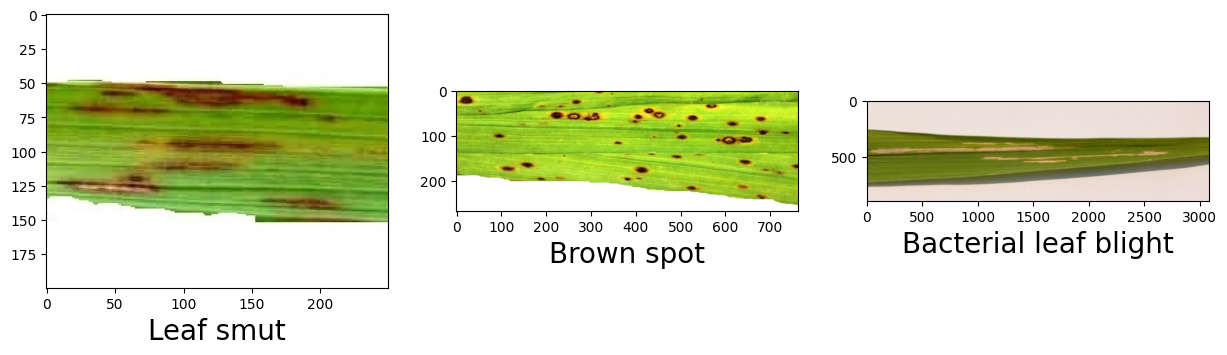

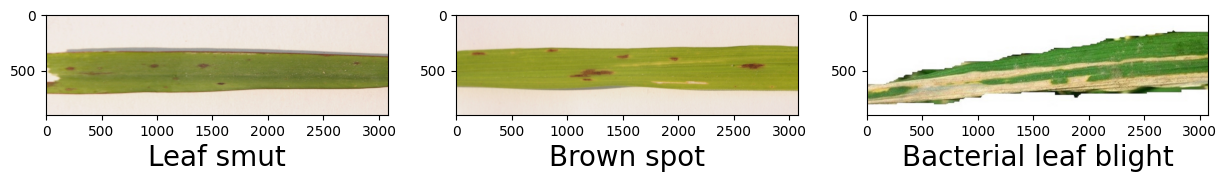

In [47]:
import matplotlib.pyplot as plt

# Set up the canvas for the subplots
plt.figure(figsize=(15, 15))

# Image 1
plt.subplot(1, 3, 1)  # 1 row and 3 columns
item = 'DSC_0512.jpg'
path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1, 3, 2)  # 1 row and 3 columns
item = 'DSC_0108.jpg'
path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 3
plt.subplot(1, 3, 3)  # 1 row and 3 columns
item = 'DSC_0402.JPG'
path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

# Set up the canvas for the second set of subplots
plt.figure(figsize=(15, 15))

# Image 1
plt.subplot(1, 3, 1)  # 1 row and 3 columns
item = 'DSC_0316.JPG'
path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Leaf smut/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Leaf smut', fontsize=20)

# Image 2
plt.subplot(1, 3, 2)  # 1 row and 3 columns
item = 'DSC_0303.JPG'
path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Brown spot/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Brown spot', fontsize=20)

# Image 3
plt.subplot(1, 3, 3)  # 1 row and 3 columns
item = 'DSC_0702.jpg'
path = '/content/drive/MyDrive/archive/rice_leaf_diseases/Bacterial leaf blight/' + item
image = plt.imread(path)
plt.imshow(image)
plt.xlabel('Bacterial leaf blight', fontsize=20)

plt.show()


## Set up and test the Augmentations

In [48]:
!pip install albumentations==0.4.6

In [49]:
# Pneumothorax - 1st place solution
# Source: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/107824#latest-620521

# Albumentations

import albumentations as albu


def augment_image(augmentation, image):

    """
    Uses the Albumentations library.

    Inputs:
    1. augmentation - this is the instance of type of augmentation to do
    e.g. aug_type = HorizontalFlip(p=1)
    # p=1 is the probability of the transform being executed.

    2. image - image with shape (h,w)

    Output:
    Augmented image as a numpy array.

    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']


    return image_matrix



In [50]:
# Define the transforms


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])



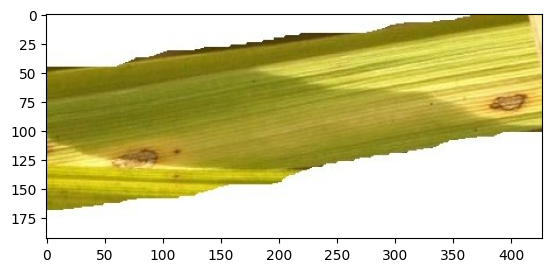

In [51]:
# Get an image to test transformations

# get a list of train png images
path = 'image_dir/'
image_list = os.listdir('image_dir')

fname = image_list[1]
image_path = path + fname

image = plt.imread(image_path)
plt.imshow(image)

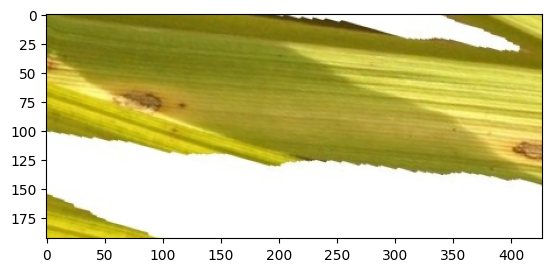

In [52]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

## Build the Data Generators

### [ 1 ] Train Generator

In [53]:
df_train.head()

,image,target_bacterial_leaf_blight,target_brown_spot,target_leaf_smut
15,DSC_0399.JPG,True,False,False
16,DSC_0509.jpg,False,False,True
17,DSC_0508.jpg,False,False,True
18,DSC_0304.JPG,False,True,False
19,DSC_0295.JPG,False,True,False


In [54]:
def train_generator(batch_size=8):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_train
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))




            # Create y_train
            # ===============
                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_train = df[cols]
                y_train = np.asarray(y_train)

                # change the shape to (batch_size, 1)
                #y_train = y_train.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size


            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)

                # insert the image into X_train
                X_train[i] = aug_image



            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train

In [55]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 3)


In [56]:
y_train

array([[ True, False, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True]])

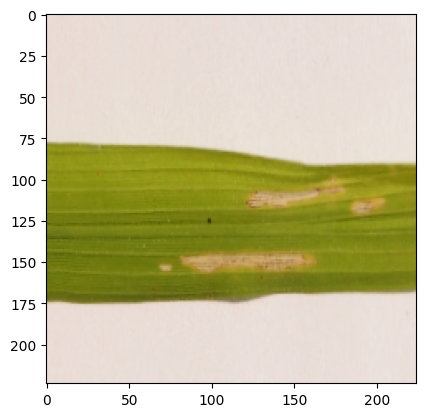

In [57]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

### [ 2 ] Val Generator

In [58]:
def val_generator(batch_size=5):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_val
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image




            # Create y_val
            # ===============

                cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
                y_val = df[cols]
                y_val = np.asarray(y_val)

                # change the shape to (batch_size, 1)
                #y_val = y_val.reshape((-1, 1)) # -1 tells numpy to automatically detect the batch size





            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [59]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 3)


In [60]:
y_val

array([[False, False,  True],
       [ True, False, False],
       [False,  True, False],
       [ True, False, False],
       [False, False,  True]])

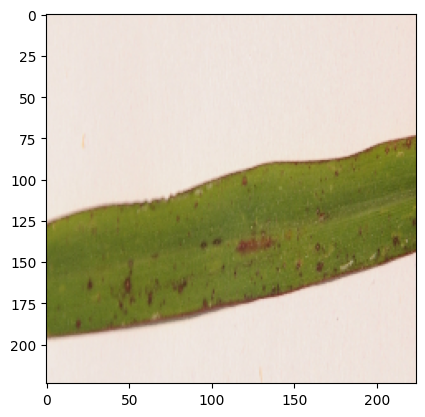

In [61]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

### [ 3 ] Test Generator

In [62]:
def test_generator(batch_size=1):

    while True:

        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):

            # get the list of images
            image_id_list = list(df['image'])

            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)




            # Create X_test
            #================

            for i in range(0, len(image_id_list)):


                # get the image and mask
                image_id = image_id_list[i]


                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)

                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image



            # Normalize the images
            X_test = X_test/255

            yield X_test

In [63]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


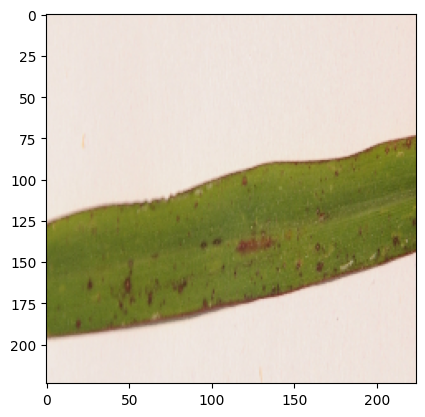

In [64]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

## Model Architecture

In [65]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


In [66]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,256,867 (16.24 MB)

 Trainable params: 4,234,979 (16.16 MB)

 Non-trainable params: 21,888 (85.50 KB)

## Train the Model

In [67]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [68]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   #verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger]

history = model.fit(
    train_gen,
    steps_per_epoch=int(train_steps),  # Ensure it's an integer
    epochs=100,
    validation_data=val_gen,
    validation_steps=int(val_steps),  # Ensure it's an integer
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.3507 - loss: 2.6997
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3597 - loss: 2.6459 - val_accuracy: 0.7333 - val_loss: 1.0935
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7921 - loss: 0.8817
Epoch 2: val_accuracy did not improve from 0.73333
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7944 - loss: 0.8753 - val_accuracy: 0.6667 - val_loss: 1.1737
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8144 - loss: 0.7746
Epoch 3: val_accuracy did not improve from 0.73333
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.8201 - loss: 0.7451 - val_accuracy: 0.4667 - val_loss: 2.5266
Epoch 4/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8734 - loss: 0.4167
Epoch 4: val_accuracy did not improve from 0.73333
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8750 - loss: 0.4170 - val_accuracy: 0.4667 - val_loss: 2.5409
Epoch 5/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9044 - loss: 0.2683
Epoch 5: val_accuracy did not imp

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.9017 - loss: 0.2323 - val_accuracy: 0.8000 - val_loss: 1.4815
Epoch 17/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9555 - loss: 0.1622
Epoch 17: val_accuracy did not improve from 0.80000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9577 - loss: 0.1576 - val_accuracy: 0.8000 - val_loss: 1.0397
Epoch 18/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9425 - loss: 0.2379
Epoch 18: val_accuracy did not improve from 0.80000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9438 - loss: 0.2391 - val_accuracy: 0.8000 - val_loss: 0.8183
Epoch 19/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9660 - loss: 0.0720
Epoch 19: val_accuracy improved from 0.80000 to 0.93333, saving model to model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9680 - loss: 0.0667 - val_accuracy: 0.9333 - val_loss: 0.2614
Epoch 20/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9787 - loss: 0.1307
Epoch 20: val_accuracy did not improve from 0.93333
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9777 - loss: 0.1363 - val_accuracy: 0.9333 - val_loss: 0.3625
Epoch 21/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9733 - loss: 0.0908
Epoch 21: val_accuracy did not improve from 0.93333
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.9730 - loss: 0.0906 - val_accuracy: 0.8000 - val_loss: 0.5390
Epoch 22/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9519 - loss: 0.0561
Epoch 22: val_accuracy did not improve from 0.93333
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9545 - loss: 0.0535 - val_accuracy: 0.9333 - val_loss: 0.2872
Epoch 23/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9976 - loss: 0.0187
Epoch 23: val_accuracy did 

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.9875 - loss: 0.0275 - val_accuracy: 1.0000 - val_loss: 0.0333
Epoch 43/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9849 - loss: 0.0543
Epoch 43: val_accuracy did not improve from 1.00000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9831 - loss: 0.0633 - val_accuracy: 1.0000 - val_loss: 0.0219
Epoch 44/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9824 - loss: 0.0340
Epoch 44: val_accuracy did not improve from 1.00000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9822 - loss: 0.0339 - val_accuracy: 1.0000 - val_loss: 0.0361
Epoch 45/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0078
Epoch 45: val_accuracy did not improve from 1.00000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9333 - val_loss: 0.1236
Epoch 46/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9966 - loss: 0.0064
Epoch 46: val_accuracy did not

In [69]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.485714,1.892548,0.733333,1.093525
1,1,0.809524,0.834329,0.666667,1.173671
2,2,0.857143,0.553010,0.466667,2.526554
3,3,0.885714,0.418900,0.466667,2.540867
4,4,0.923810,0.213552,0.600000,2.297863


## Evaluate the model on the val set

In [70]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

In [71]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

val_loss, val_acc = \
model.evaluate(val_gen,steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0243
val_loss: 0.03332899883389473
val_acc: 1.0


## Plot the training curves

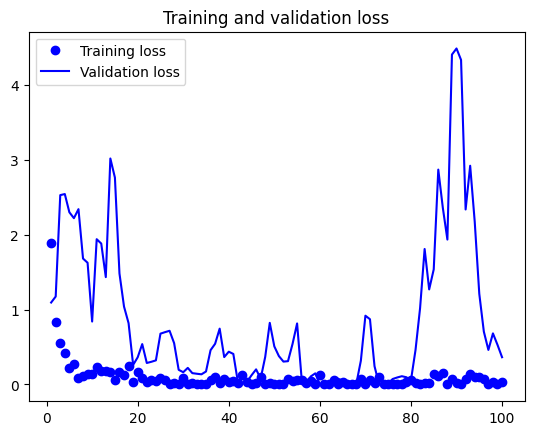

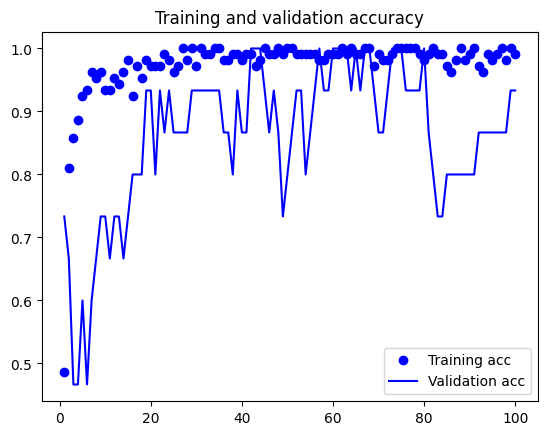

<Figure size 640x480 with 0 Axes>

In [72]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

## Make a prediction on the val set

In [73]:
def test_generator(batch_size=1):
    # Get a list of image paths from the 'image' column of df_val
    test_image_paths = df_val['image'].apply(lambda x: os.path.join('image_dir', x)).tolist()

    while True:  # Add a while loop for continuous generation
        for i in range(0, len(test_image_paths), batch_size):
            # Process images in batches
            batch_image_paths = test_image_paths[i:i + batch_size]
            batch_images = []
            for image_path in batch_image_paths:
                # Since preprocess_image is not defined, reading the image directly using cv2
                img = cv2.imread(image_path)
                # Assuming preprocessing involves resizing and normalization
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB if necessary
                img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))  # Resize to desired dimensions
                img = img / 255.0  # Normalize pixel values
                batch_images.append(img)

            # Yield the batch of images and dummy targets as a tuple
            yield np.array(batch_images), np.zeros((len(batch_images), 3)) # Dummy targets with shape (batch_size, 3)

In [74]:
# get the predicted probabilities
test_gen = test_generator(batch_size=1)  # Assuming test_generator is defined
preds = model.predict(test_gen, steps=len(df_val))

# get y_pred as index values
y_pred = np.argmax(preds, axis=1)

y_pred

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


array([2, 0, 1, 0, 2, 1, 2, 1, 0, 2, 1, 0, 1, 0, 2])

In [75]:
# get y_true as index values

cols = ['target_bacterial_leaf_blight', 'target_brown_spot', 'target_leaf_smut']
y_true = df_val[cols]
y_true = np.asarray(y_true)

y_true = np.argmax(y_true, axis=1)

y_true

array([2, 0, 1, 0, 2, 1, 2, 1, 0, 2, 1, 0, 1, 0, 2])

In [76]:
# Compare y_true and y_pred

print(y_pred)
print(y_true)

[2 0 1 0 2 1 2 1 0 2 1 0 1 0 2]
[2 0 1 0 2 1 2 1 0 2 1 0 1 0 2]


## Confusion Matrix

In [77]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[5 0 0]
 [0 5 0]
 [0 0 5]]


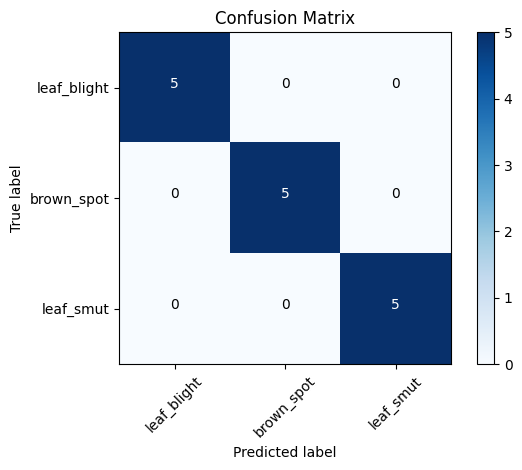

In [78]:
# bacterial_leaf_blight = 0
# brown_spot = 1
# leaf_smut = 2

cm_plot_labels = ['leaf_blight', 'brown_spot', 'leaf_smut']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Classification Report

In [79]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['bacterial_leaf_blight', 'brown_spot', 'leaf_smut'])

print(report)

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00         5
           brown_spot       1.00      1.00      1.00         5
            leaf_smut       1.00      1.00      1.00         5

             accuracy                           1.00        15
            macro avg       1.00      1.00      1.00        15
         weighted avg       1.00      1.00      1.00        15



**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

## Convert the Model to Tensorflow.js

In [86]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.8/451.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.

In [85]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

/bin/bash: line 1: tensorflowjs_converter: command not found


In [82]:
# check that the folder containing the tfjs model files has been created
!ls

2		    df_train.csv.gz  drive	image_dir22  sample_data
df_combined.csv.gz  df_val.csv.gz    image_dir	model.h5     training_log.csv


In [83]:
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

# shutil.rmtree('image_dir')

In [84]:
!ls

2		    df_train.csv.gz  drive	image_dir22  sample_data
df_combined.csv.gz  df_val.csv.gz    image_dir	model.h5     training_log.csv


## Citations

- Prajapati HB, Shah JP, Dabhi VK. Detection and classification of rice plant diseases. Intelligent Decision Technologies. 2017 Jan 1;11(3):357-73, doi: 10.3233/IDT-170301.

- Ref Paper:<br>
Detection and classification of rice plant diseases
https://www.researchgate.net/publication/318437440_Detection_and_classification_of_rice_plant_diseases

- Header image by HoangTuan_photography on Pixabay


## Helpful Resources

- Albumentations paper:<br>
Albumentations: fast and flexible image augmentations<br>
https://arxiv.org/abs/1809.06839

- If you would like to learn how to build Tensorflow.js web apps I recommend this video tutorial:<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

- I've also included a few practical app implementation tips on the readme page in this repo:<br>
https://github.com/vbookshelf/Skin-Lesion-Analyzer

## Conclusion

Here are a few things you could try:
- Implement 10 fold cross validation.
- Use a different pre-trained model e.g. Densenet169 or Resnet18.
- Use different image pre-processing methods.
- Use a different augmentation setup or none at all.

Thank you for reading.